## Eng+Wales well-mixed model MCMC

This is the evidence notebook.  There are various model variants as encoded by `expt_params_local` and `model_local`, which are shared by the notebooks in a given directory.

On running, this notebook starts a new evidence computation, *or* picks up a list of existing samplers and continues running MCMC for each sampler.  This is controlled by `doTI` and `moreSamples`.

**Note** : Depending on parameters and compute power, this may take days to run.

Outputs of this notebook:
* `ewMod-TI.pik` : result of MCMC computation at each quadrature site (very large file in general, not included in repo)

**Note carefully** : internal details of .pik files that are created by this notebook and -- hence the option to continue existing computations -- may be affected by changes to pyross source code.  It is therefore useful to keep track of the specific commitID used for a given run.
I am using git commit `be4eabc` .

### start notebook

(the following line is for efficient parallel processing)

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
import pandas as pd
import matplotlib.image as mpimg
import pickle
import os
import pprint
import emcee
from scipy.stats import multivariate_normal, lognorm
import dill
import pathos.multiprocessing as pathos_mp
import scipy.stats

In [3]:
#from   ew_fns import *
from   uk_v2a_fns import *  ## these are exactly the same functions as ew_fns, 
                            ## imported like this for compatibility with saved pik files (legacy)
import expt_params_local
import model_local

In [4]:
#print(pyross.__file__)
#print(os.getcwd())

np.set_printoptions(precision=3) 
pltAuto = True
plt.rcParams.update({'figure.autolayout': pltAuto})
plt.rcParams.update({'font.size': 14})

In [5]:
verboseMod=False

## time unit is one week
daysPerWeek = 7.0

doTI = False         ## run the MCMC for the thermodynamic integration
moreSamples = False  ## run each chain for longer.

## these are params that might be varied in different expts
exptParams = expt_params_local.getLocalParams() 

pprint.pprint(exptParams)

## this is used for filename handling throughout
pikFileRoot = exptParams['pikFileRoot']

## Configure the evidence computation:
evidenceParams = {
    'num_steps': 80,          ## The number of quadrature points for TI.
    'step_pow': 2,            ## Distribution of quadrature points. The points are distributed 
                              ## as `np.linspace(0, 1, num=num_steps)[1:]**step_pow`.
    'mcmc_steps': 3000,       ## Number of steps in the MCMC chains at each quadrature point.
    'mcmc_population': 100,   ## The population of the MCMC ensemble sampler
    'mcmc_discard': 1/3,      ## How much of the chain to throw away for burn-in.
    'nprocesses': 8,          ## The number of processes used.
    'add_samples': 1000,      ## if moreSamples==True, add this many samples to each chain.
    'init_samples': 20000     ## Samples of the Laplace approx. Non-feasible samples get rejected.
}

{'careFile': '../data/CareHomes.csv',
 'chooseCM': 'fumanelliEtAl',
 'dataFile': '../data/OnsData.csv',
 'estimatorTol': 1e-08,
 'exCare': True,
 'forecastTime': 3,
 'freeInitPriors': ['E', 'A', 'Is1', 'Is2', 'Is3'],
 'infOptions': {'cma_population': 32,
                'cma_processes': None,
                'ftol': 5e-05,
                'global_atol': 1.0,
                'global_max_iter': 1500,
                'local_max_iter': 400},
 'inferBetaNotAi': True,
 'numCohorts': 16,
 'numCohortsPopData': 19,
 'pikFileRoot': 'ewMod',
 'popFile': '../data/EWAgeDistributedNew.csv',
 'timeLast': 8,
 'timeZero': 0}


## LOAD MODEL and RESULTS

In [6]:
loadModel = model_local.loadModel(exptParams,daysPerWeek,verboseMod) 

## should use a dictionary but...
[ numCohorts, fi, N, Ni, model_spec, estimator, contactBasis, interventionFn,
   modParams, priorsAll, initPriorsLinMode, obsDeath, fltrDeath, 
   simTime, deathCumulativeDat ] = loadModel

** model

{'A': {'infection': [], 'linear': [['E', 'gammaE'], ['A', '-gammaA']]},
 'E': {'infection': [['A', 'beta'],
                     ['Is1', 'beta'],
                     ['Is2', 'betaLate'],
                     ['Is3', 'betaLate']],
       'linear': [['E', '-gammaE']]},
 'Im': {'infection': [], 'linear': [['Is3', 'cfr*gammaIs3']]},
 'Is1': {'infection': [],
         'linear': [['A', 'gammaA'],
                    ['Is1', '-alphabar*gammaIs1'],
                    ['Is1', '-alpha*gammaIs1']]},
 'Is2': {'infection': [],
         'linear': [['Is1', 'alphabar*gammaIs1'], ['Is2', '-gammaIs2']]},
 'Is3': {'infection': [],
         'linear': [['Is2', 'gammaIs2'],
                    ['Is3', '-cfrbar*gammaIs3'],
                    ['Is3', '-cfr*gammaIs3']]},
 'S': {'infection': [['A', '-beta'],
                     ['Is1', '-beta'],
                     ['Is2', '-betaLate'],
                     ['Is3', '-betaLate']],
       'linear': []},
 'classes': ['S', 'E', 'A', 'Is1', 'Is2', 'Is

### load inference result

In [7]:
print('Load inference result')
    
# load...
ipFile = pikFileRoot + "-inf.pik"
print('ipf',ipFile)
with open(ipFile, 'rb') as f: 
    [infResult,elapsedInf] = pickle.load(f)

ipFile = pikFileRoot + "-hess.npy"
print('ipf',ipFile)
with open(ipFile, 'rb') as f: 
    hessian = np.load(f)

Load inference result
ipf ewMod-inf.pik
ipf ewMod-hess.npy


## EVIDENCE
Compute the evidence using thermodynamic integraion. For an explanation of the method, see Appendix B.2 of the paper.

#### Functions for computing the evidence

In [13]:
logl, prior, ndim = pyross.evidence.latent_get_parameters(estimator, obsDeath, fltrDeath, simTime, 
                                    priorsAll, initPriorsLinMode, generator=contactBasis, 
                                    intervention_fun=interventionFn, tangent=False)
class PrecisionGaussian:
    """Stable implementation of a multivariate Gaussian density that works with very 
    ill-conditioned precision matrices.
    """
    def __init__(self, mean, precision_matrix):
        self.pm = precision_matrix
        self.mean = mean
        self.dim = len(mean)
        self.logdet = np.linalg.slogdet(self.pm)[1]
        self.uninormal = scipy.stats.multivariate_normal(cov=np.eye(len(mean)))
        
        # Compute stable decompositon of covariance matrix
        chol = scipy.linalg.cholesky(self.pm, lower=False)
        self.L = scipy.linalg.lapack.dtrtri(chol, lower=0)[0]

    def logpdf(self, x):
        c = x - self.mean
        return -1/2 * (self.dim * np.log(2*np.pi) - self.logdet) - 1/2 * c.T @ self.pm @ c
        
    def rvs(self, *args, **kwargs):
        x = self.uninormal.rvs(*args, **kwargs)
        return (self.L@x.T).T + self.mean

laplace_post = PrecisionGaussian(infResult['flat_params'], hessian)

num_steps = evidenceParams['num_steps']
mcmc_steps = evidenceParams['mcmc_steps']
npopulation = evidenceParams['mcmc_population']
step_pow = evidenceParams['step_pow']
burn_in = int(np.floor(evidenceParams['mcmc_discard'] * mcmc_steps))
nprocesses = evidenceParams['nprocesses']

second_schedule = np.linspace(0, 1, num=num_steps)[1:]**step_pow
new_val1 = second_schedule[-2] + (second_schedule[-1] - second_schedule[-2])/3
new_val2 = second_schedule[-2] + 2*(second_schedule[-1] - second_schedule[-2])/3
second_schedule = np.array([*(second_schedule[:-1]), new_val1, new_val2, second_schedule[-1]])

logp = lambda params: np.sum(prior.logpdf(params))

def intermed_distr2(params, step):
    return step*(logl(params) + logp(params)) +  (1-step)*laplace_post.logpdf(params)

def run_ti_2(init_positions):
    mcmc_pool = pathos_mp.ProcessingPool(nprocesses)

    sampler_list = []

    print("Start main iteration...")
    for step in second_schedule:
        print("Step", step)
        sampler = emcee.EnsembleSampler(npopulation, ndim, intermed_distr2, pool=mcmc_pool, kwargs={'step':step})
        sampler.run_mcmc(init_positions, mcmc_steps, progress=True)

        sampler_list.append(sampler)
        init_positions = sampler.get_last_sample().coords
    
    mcmc_pool.close()
    mcmc_pool.join()
    mcmc_pool.clear()

    return sampler_list

def get_likelihood_second(step_list, sampler_list, burn_in=0, thin=1, reduce=1):
    logl_vals = []
    logl_lpl_vals = []
    for i in range(0, len(step_list)):
        if i%10 == 0:
            print("get_likelihood_second: {}/{}".format(i, len(step_list)-1))

        step = step_list[i]
        chain = sampler_list[i].get_chain(discard=burn_in, flat=True, thin=thin)
        chain_length = len(chain)
        log_probs = sampler_list[i].get_log_prob(discard=burn_in, flat=True, thin=thin)

        if reduce > 1:
            reduced_length = int(np.floor(chain_length / reduce))
            chain = chain[0:reduced_length]
            log_probs = log_probs[0:reduced_length]

        # Get likelihood values from log_probs
        logpdf_laplace = np.array(list(map(laplace_post.logpdf, chain)))
        logprior = np.array(list(map(logp, chain)))
        llike_laplace = logpdf_laplace - logprior
        llike = 1/step * (log_probs - (1-step)*logpdf_laplace) - logprior

        logl_vals.append(llike)
        logl_lpl_vals.append(llike_laplace)

    return logl_vals, logl_lpl_vals

def sample_truncated_laplace_approx(N):
    """Sample the Laplace approximation restricted to the support of the likelihood."""
    mcmc_pool = pathos_mp.ProcessingPool(nprocesses)

    points = laplace_post.rvs(N)
    values = np.array(list(mcmc_pool.map(logl, points)))
    laplace_samples = points[values != -np.Inf, :]
    logl_values = values[values != -np.Inf]    

    mcmc_pool.close()
    mcmc_pool.join()
    mcmc_pool.clear()

    return laplace_samples, logl_values

#### Run the evidence computation

In [9]:
# 1) Sample the truncated Laplace approximation. This is used as initial samples for the thermodynamic
#    integration run, to compute \E_{\pi_0}[L - \tilde L], and to estimate the normalisation factor of
#    the truncated Laplace approximation.
N = evidenceParams['init_samples']
laplace_samples, logl_values = sample_truncated_laplace_approx(N)
nr = len(laplace_samples)
if nr < npopulation:
    raise Error("Not enough samples.")

init_positions = laplace_samples[0:npopulation, :]

trunclaplace_weight = nr / N
trunclaplace_weight_std = np.sqrt(1/(N-1) * (nr * (1-trunclaplace_weight)**2 + (N-nr) * trunclaplace_weight**2)) \
                                / np.sqrt(N)

weightcorr = np.log(trunclaplace_weight)
weightcorr_err_1 = weightcorr - np.log(trunclaplace_weight + trunclaplace_weight_std)
weightcorr_err_2 = weightcorr - np.log(trunclaplace_weight - trunclaplace_weight_std)
weightcorr_err = np.max([weightcorr_err_1, weightcorr_err_2]);

In [11]:
# 2) Run the main course of the thermodynamic integration, getting samples for \pi_s for all scheduled s > 0.
#    This will take a long time.
if doTI:
    ti_sampler_list = run_ti_2(init_positions)
    opFile = pikFileRoot + "-TI.pik"
    print('opf',opFile)
    with open(opFile, 'wb') as f: 
        dill.dump([ti_sampler_list], f)

opFile = pikFileRoot + "-TI.pik"
with open(opFile, 'rb') as f: 
    ti_sampler_list = dill.load(f)[0];

get_likelihood_second: 0/80
get_likelihood_second: 10/80
get_likelihood_second: 20/80
get_likelihood_second: 30/80
get_likelihood_second: 40/80
get_likelihood_second: 50/80
get_likelihood_second: 60/80
get_likelihood_second: 70/80
get_likelihood_second: 80/80


Text(0.5, 1.0, 'Stochastic error')

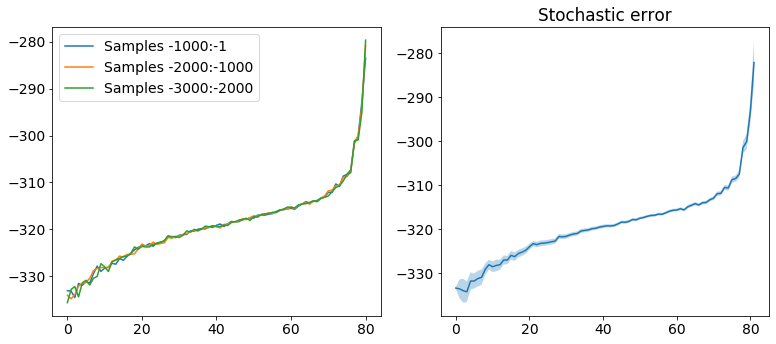

In [14]:
# 3) Collect results (expected values & corresponding estimated standard deviations).
# 3.1) Compute expectation for s=0:
laplacepost_values = np.array(list(map(laplace_post.logpdf, laplace_samples)))
prior_values = np.array(list(map(logp, laplace_samples)))
laplacelogl_values = laplacepost_values - prior_values
result_schedule = [0]
result_values = [np.mean(logl_values - laplacelogl_values)]
result_stds = [np.std(logl_values - laplacelogl_values) / np.sqrt(len(logl_values))]

# 3.2) Compute expectations for s>0:
logl_vals, logl_lpl_vals = get_likelihood_second(second_schedule, ti_sampler_list, burn_in=burn_in, thin=50)
target_vals = [logl_vals[i] - logl_lpl_vals[i] for i in range(len(logl_vals))]
n_val = len(target_vals)
vals = np.mean([target_vals[i][-4000:] for i in range(n_val)], axis=1) # Take last 2000 samples.
vals_var = np.var([target_vals[i][-4000:] for i in range(n_val)], axis=1)
result_schedule = [*result_schedule, *second_schedule]
result_values = [*result_values, *vals]
# The chain is not long enough to estimate the autocorrelation time accurately, so we just assume 
# one effective sample per ensemble member.
effective_sample_nr = 1

result_vars = [result_stds[0]**2, *(vals_var / (effective_sample_nr * npopulation))]

# Look at integrand.
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
vals1 = np.mean([target_vals[i][-2000:] for i in range(n_val)], axis=1) # Take last 1000 samples.
vals2 = np.mean([target_vals[i][-4000:-2000] for i in range(n_val)], axis=1)
vals3 = np.mean([target_vals[i][-6000:-4000] for i in range(n_val)], axis=1)
plt.plot(vals1, label="Samples -1000:-1")
plt.plot(vals2, label="Samples -2000:-1000")
plt.plot(vals3, label="Samples -3000:-2000")
plt.legend()

plt.subplot(1,2,2)
plt.plot(result_values)
plt.fill_between(list(range(len(result_values))), np.array(result_values) - np.sqrt(result_vars), 
                 np.array(result_values)+np.sqrt(result_vars), alpha=0.3)
plt.title("Stochastic error")

#### 4.1) Estimate the variance
We assume that each element in `result_values` is an independent estimate $\hat f'_i$ of $f'(s_i)$ with (estimated) variance $v_i$.
We can compute an estimate of the variance of
$$
    F \approx \sum_{i=1}^{n} \frac{1}{2} (s_i - s_{i-1}) * (f'_i + f'_{i-1}))
        = \frac{1}{2} \left( (s_1 - s_0) f'_0 + \sum_{i=1}^{n-1} (s_{i+1} - s_{i-1})f'_i + (s_n - s_{n-1}) f'_n \right)
$$
as
$$
    \text{var}\, F = \frac{1}{4} \left( (s_1 - s_0)^2 v_0 + \sum_{i=1}^{n-1} (s_{i+1} - s_{i-1})^2 v_i + (s_n - s_{n-1})^2 v_n \right).
$$
Note, that this is only an estimate of the random error and does not take into account the quadrature error.

In [15]:
# 4) Compute integral using trapezoidal rule
log_evidence = 0.0
value_list = []
for i in range(1, len(result_schedule)):
    log_evidence += 1/2 * (result_schedule[i] - result_schedule[i-1]) * (result_values[i] + result_values[i-1])
    value_list.append(log_evidence)

variance = (result_schedule[1] - result_schedule[0])**2*result_vars[0] + (result_schedule[-1] - result_schedule[-2])**2*result_vars[-1]
for i in range(1, len(result_schedule)-1):
    variance += (result_schedule[i+1] - result_schedule[i-1])**2*result_vars[i]
variance *= 1/4
std_deviation = np.sqrt(variance)

# Account for the normalisation of $\tilde L$ in the estimate.
log_evidence -= weightcorr
std_deviation += weightcorr_err

# Final result:
print("Log-evidence = {}".format(log_evidence))
print("(Estimated standard deviation = {})".format(std_deviation))

Log-evidence = -315.49265639145324
(Estimated standard deviation = 0.07997181629808899)


In [16]:
# 5) Continue running the chains, if needed.
if moreSamples:
    additional_steps = evidenceParams['add_samples']

    mcmc_pool = pathos_mp.ProcessingPool(nprocesses)
    for sampler in ti_sampler_list:
        sampler.pool = mcmc_pool
        sampler.run_mcmc(None, additional_steps, progress=True)

    mcmc_pool.close()
    mcmc_pool.join()
    mcmc_pool.clear()
    
    opFile = pikFileRoot + "-TI.pik"
    print('opf',opFile)
    with open(opFile, 'wb') as f: 
        dill.dump([ti_sampler_list], f)